In [6]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
from scipy.stats import pointbiserialr
import seaborn as sns
from sklearn.utils import resample
import matplotlib.patches as patches

matplotlib.rcParams['font.family'] = 'Times New Roman'

In [2]:
imagenes = './images'
file_path = "./merged_file.json"

with open(file_path, 'r') as file:
    json_data = file.read()
    
data = json.loads(json_data)

In [3]:
anomalous_data = []  

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (x, y, w, h, anomalous) in bboxes:
        color = 'r' if anomalous else 'g' 
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

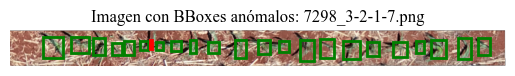

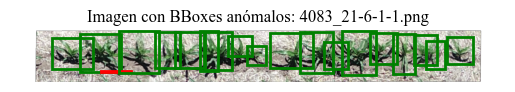

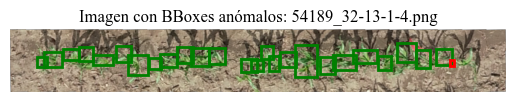

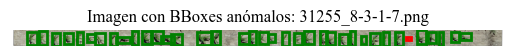

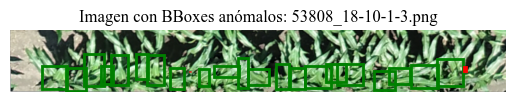

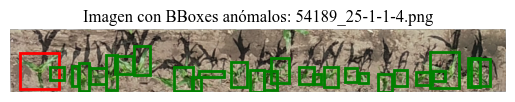

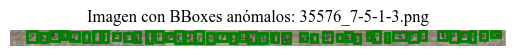

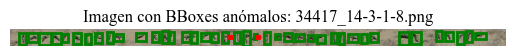

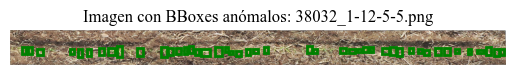

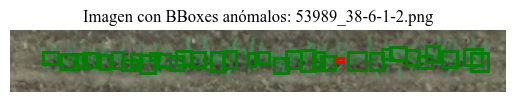

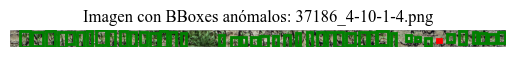

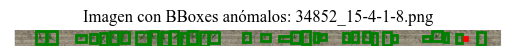

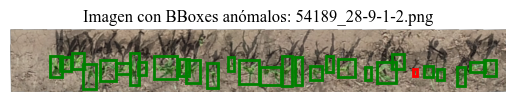

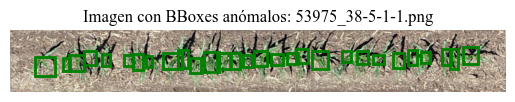

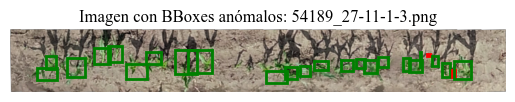

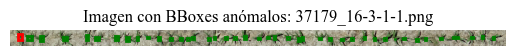

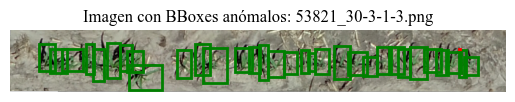

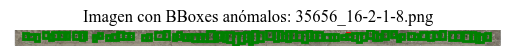

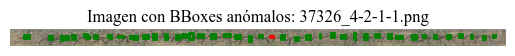

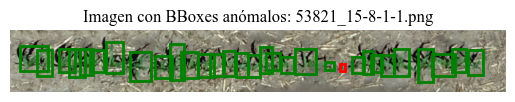

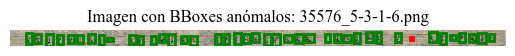

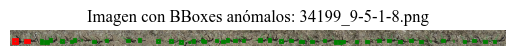

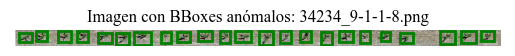

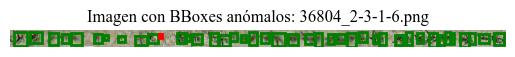

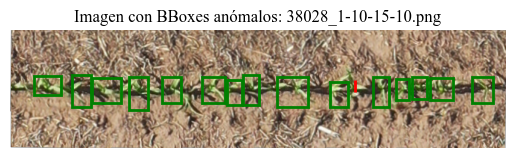

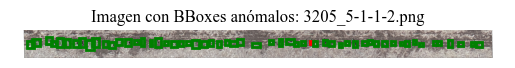

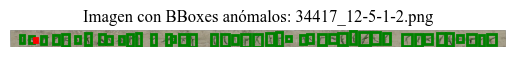

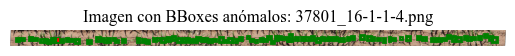

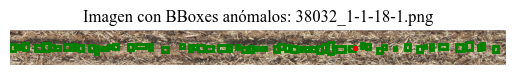

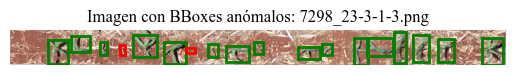

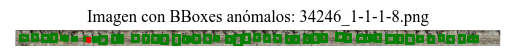

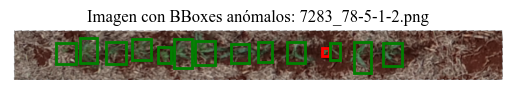

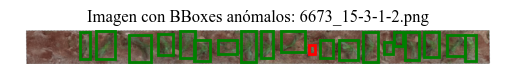

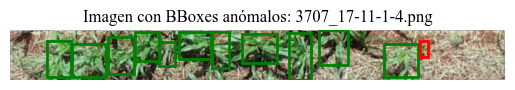

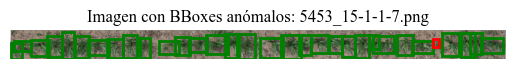

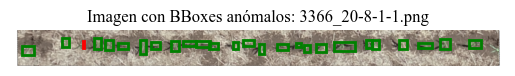

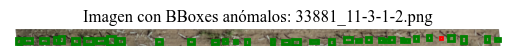

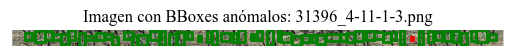

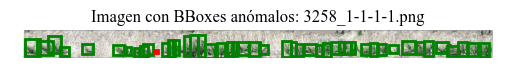

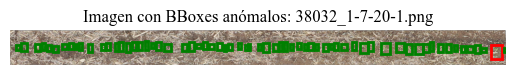

In [7]:
for item in data:
    annotations = item.get('annotations', [])
    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_name = item['item']['name']  

    areas = []
    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        area = w * h
        areas.append(area)
        bboxes_details.append((x, y, w, h))

    if areas:
        median_area = np.median(areas)
        threshold_upper = 5 * median_area
        threshold_lower = 0.15 * median_area

        annotated_bboxes = []
        show = False
        for (x, y, w, h), area in zip(bboxes_details, areas):
            anomalous = area > threshold_upper or area < threshold_lower
            annotated_bboxes.append((x, y, w, h, anomalous))
            if anomalous:
                anomalous_data.append({
                    'Image Name': image_name,
                    'X': x,
                    'Y': y,
                    'Width': w,
                    'Height': h,
                    'Anomalous Area': area,
                    'Median Area': median_area
                })
                show = True

        if show:
            show_image_with_boxes(image_url, annotated_bboxes, f"Imagen con BBoxes anómalos: {image_name}")

# Images con Overlapping

In [8]:
def calculate_overlap(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    intersection_area = x_overlap * y_overlap
    area1 = w1 * h1
    area2 = w2 * h2
    return intersection_area / min(area1, area2)

In [9]:
overlapping_images = []

for item in data:
    annotations = item.get('annotations', [])
    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_name = item['item']['name']  

    areas = []
    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        areas.append(w * h)
        bboxes_details.append((x, y, w, h))

    if areas:
        median_area = np.median(areas)
        threshold_upper = 5 * median_area
        threshold_lower = 0.15 * median_area

        annotated_bboxes = []
        show = False
        for (x, y, w, h), area in zip(bboxes_details, areas):
            anomalous = area > threshold_upper or area < threshold_lower
            annotated_bboxes.append((x, y, w, h, anomalous))
            if anomalous:
                show = True

        for i, bbox1 in enumerate(bboxes_details):
            for j, bbox2 in enumerate(bboxes_details):
                if i != j:
                    overlap = calculate_overlap(bbox1, bbox2)
                    if overlap > 0.9:
                        show = True
                        overlapping_images.append(image_name)  
                        break
            if show:
                break

In [10]:
for image_name in overlapping_images:
    print("Nombre de la imagen con superposición:", image_name)

Nombre de la imagen con superposición: 53980_42-3-1-4.png
Nombre de la imagen con superposición: 54118_6-2-4-4.png
Nombre de la imagen con superposición: 53855_10-8-1-3.png
Nombre de la imagen con superposición: 54189_32-3-1-3.png
Nombre de la imagen con superposición: 53855_38-8-1-1.png
Nombre de la imagen con superposición: 5711_36-5-1-4.png
Nombre de la imagen con superposición: 3707_18-1-1-4.png
Nombre de la imagen con superposición: 53855_16-6-1-4.png


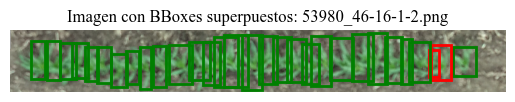

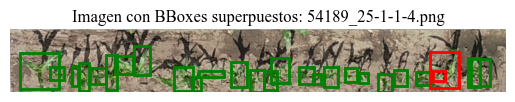

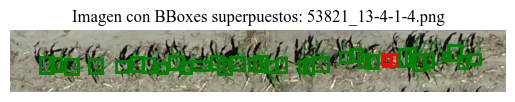

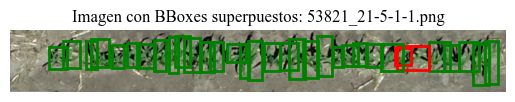

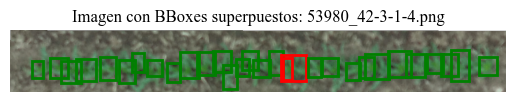

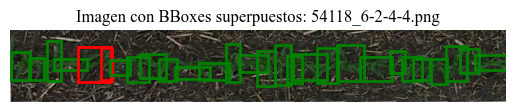

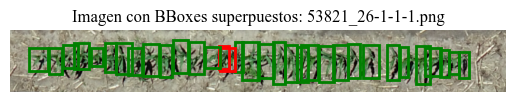

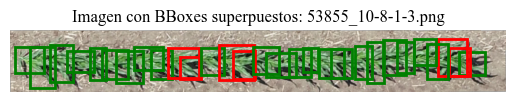

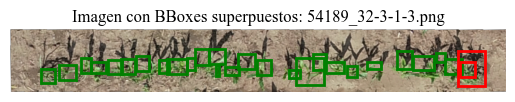

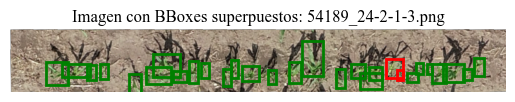

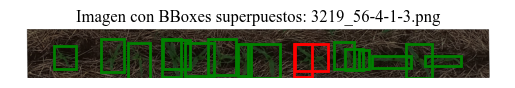

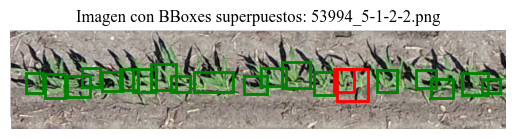

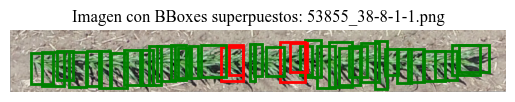

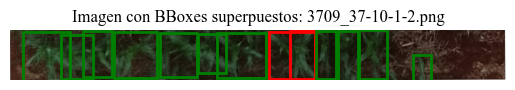

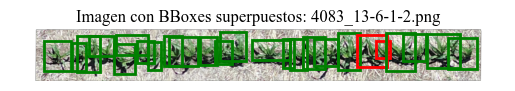

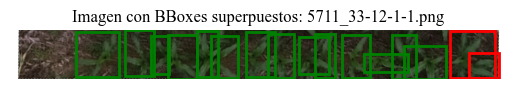

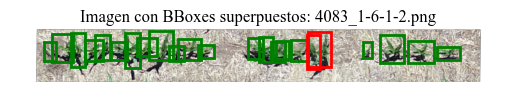

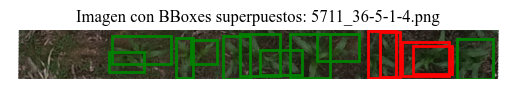

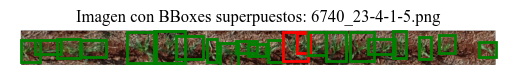

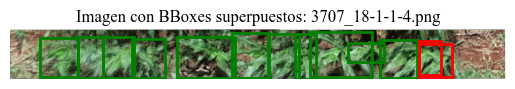

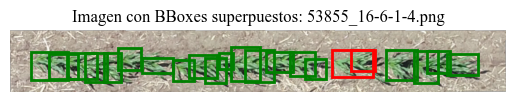

{'Image Name': '53980_46-16-1-2.png', 'BBox 1': (978.56, 35.46, 46.09, 82.26), 'BBox 2': (974.31, 47.51, 22.69, 60.98), 'Intersection Area': 1124.4712000000034, 'Area BBox 1': 3791.3634000000006, 'Area BBox 2': 1383.6362}
{'Image Name': '53980_46-16-1-2.png', 'BBox 1': (974.31, 47.51, 22.69, 60.98), 'BBox 2': (978.56, 35.46, 46.09, 82.26), 'Intersection Area': 1124.4712000000034, 'Area BBox 1': 1383.6362, 'Area BBox 2': 3791.3634000000006}
{'Image Name': '54189_25-1-1-4.png', 'BBox 1': (918.42, 48.87, 62.53, 79.27), 'BBox 2': (924.33, 90.23, 26.59, 22.89), 'Intersection Area': 608.6451000000008, 'Area BBox 1': 4956.7531, 'Area BBox 2': 608.6451}
{'Image Name': '54189_25-1-1-4.png', 'BBox 1': (924.33, 90.23, 26.59, 22.89), 'BBox 2': (918.42, 48.87, 62.53, 79.27), 'Intersection Area': 608.6451000000008, 'Area BBox 1': 608.6451, 'Area BBox 2': 4956.7531}
{'Image Name': '53821_13-4-1-4.png', 'BBox 1': (876.5, 61.56, 20.96, 17.15), 'BBox 2': (880.31, 55.84, 32.4, 28.59), 'Intersection Area'

In [11]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def calculate_intersection_area(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    if x_right < x_left or y_bottom < y_top:
        return 0
    else:
        intersection_area = (x_right - x_left) * (y_bottom - y_top)
        return intersection_area

def show_image_with_boxes(image_url, bboxes, title):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    plt.figure()
    plt.imshow(image)
    ax = plt.gca()

    for (x, y, w, h, color) in bboxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.title(title)
    plt.axis('off')
    plt.show()

anomalous_data = []

for item in data:
    annotations = item.get('annotations', [])
    image_url = item['item']['slots'][0]['source_files'][0]['url']
    image_name = item['item']['name']

    bboxes_details = []
    for anno in annotations:
        x, y, w, h = anno['bounding_box']['x'], anno['bounding_box']['y'], anno['bounding_box']['w'], anno['bounding_box']['h']
        bboxes_details.append((x, y, w, h))

    show = False
    annotated_bboxes = []
    for i in range(len(bboxes_details)):
        bbox = bboxes_details[i]
        color = 'g'
        for j in range(len(bboxes_details)):
            if i != j:
                bbox2 = bboxes_details[j]
                intersection_area = calculate_intersection_area(bbox, bbox2)
                area_bbox1 = bbox[2] * bbox[3]
                area_bbox2 = bbox2[2] * bbox2[3]
                if intersection_area > 0.8 * area_bbox1 or intersection_area > 0.8 * area_bbox2:
                    color = 'r'
                    anomalous_data.append({
                        'Image Name': image_name,
                        'BBox 1': bbox,
                        'BBox 2': bbox2,
                        'Intersection Area': intersection_area,
                        'Area BBox 1': area_bbox1,
                        'Area BBox 2': area_bbox2
                    })
                    break
        annotated_bboxes.append((*bbox, color))
        if color == 'r':
            show = True

    if show:
        show_image_with_boxes(image_url, annotated_bboxes, f"Imagen con BBoxes superpuestos: {image_name}")

# Procesar los datos anomalos encontrados
for anomaly in anomalous_data:
    print(anomaly)


# Identificacion de patrones entre caracteristicas e imagenes anomalas

In [12]:
df_anomalous_images = pd.DataFrame(anomalous_data)
print(df_anomalous_images)

             Image Name                            BBox 1  \
0   53980_46-16-1-2.png     (978.56, 35.46, 46.09, 82.26)   
1   53980_46-16-1-2.png     (974.31, 47.51, 22.69, 60.98)   
2    54189_25-1-1-4.png     (918.42, 48.87, 62.53, 79.27)   
3    54189_25-1-1-4.png     (924.33, 90.23, 26.59, 22.89)   
4    53821_13-4-1-4.png      (876.5, 61.56, 20.96, 17.15)   
5    53821_13-4-1-4.png      (880.31, 55.84, 32.4, 28.59)   
6    53821_21-5-1-1.png     (912.53, 37.98, 75.51, 54.82)   
7    53821_21-5-1-1.png     (908.23, 41.47, 37.89, 40.04)   
8    53980_42-3-1-4.png     (635.56, 64.48, 21.05, 51.32)   
9    53980_42-3-1-4.png       (630.29, 57.9, 57.9, 60.53)   
10    54118_6-2-4-4.png     (134.92, 33.03, 64.11, 69.84)   
11    54118_6-2-4-4.png     (179.65, 34.57, 21.37, 63.67)   
12   53821_26-1-1-1.png     (494.04, 43.58, 37.24, 53.23)   
13   53821_26-1-1-1.png     (492.47, 38.07, 23.34, 54.02)   
14   53855_10-8-1-3.png     (320.08, 36.13, 63.46, 60.69)   
15   53855_10-8-1-3.png 

In [13]:
print(df_anomalous_images.columns)

Index(['Image Name', 'BBox 1', 'BBox 2', 'Intersection Area', 'Area BBox 1',
       'Area BBox 2'],
      dtype='object')


In [17]:
imageFeatures = pd.read_csv('./imageFeatures.csv')
imageFeatures['isAnomaly'] = imageFeatures['image_name'].isin(df_anomalous_images['Image Name']).astype(int)
# imageFeatures = imageFeatures.drop(['layout_id', 'country', 'coincidencia', 'relevant (new) tags', 'trial_id', 'red', 'blue', 'green'], axis=1)

In [18]:
# df_anomalous_images = df_anomalous_images.drop(['X', 'Y', 'Width', 'Height', 'Anomalous Area','Median Area'], axis=1)

In [19]:
df_anomalous = imageFeatures[imageFeatures['isAnomaly'] == 1]
df_normal = imageFeatures[imageFeatures['isAnomaly'] == 0]

In [20]:
df_normal_resampled = resample(df_normal, replace=True, n_samples=len(df_anomalous), random_state=42)

In [21]:
imageFeatures_balanced = pd.concat([df_anomalous, df_normal_resampled])

In [22]:
correlation_with_isAnomaly = {}
for column in imageFeatures_balanced.columns:
    if column != 'image_name' and column != 'isAnomaly': 
        correlation, p_value = pointbiserialr(imageFeatures_balanced[column], imageFeatures_balanced['isAnomaly'])
        correlation_with_isAnomaly[column] = correlation

In [23]:
correlation_df = pd.DataFrame.from_dict(correlation_with_isAnomaly, orient='index', columns=['Correlation_with_isAnomaly'])

correlation_df = correlation_df.reindex(correlation_df['Correlation_with_isAnomaly'].abs().sort_values(ascending=False).index)

print("Correlation of features with isAnomaly:")
print(correlation_df)

Correlation of features with isAnomaly:
                 Correlation_with_isAnomaly
mean_hue                           0.540902
mean_saturation                   -0.302608
layout_id                          0.296249
contrast                          -0.254266
bluriness                         -0.254266
blue                               0.138202
green                              0.124253
red                               -0.053836
entropy                           -0.022534
area                               0.016083
mean_brightness                    0.004305


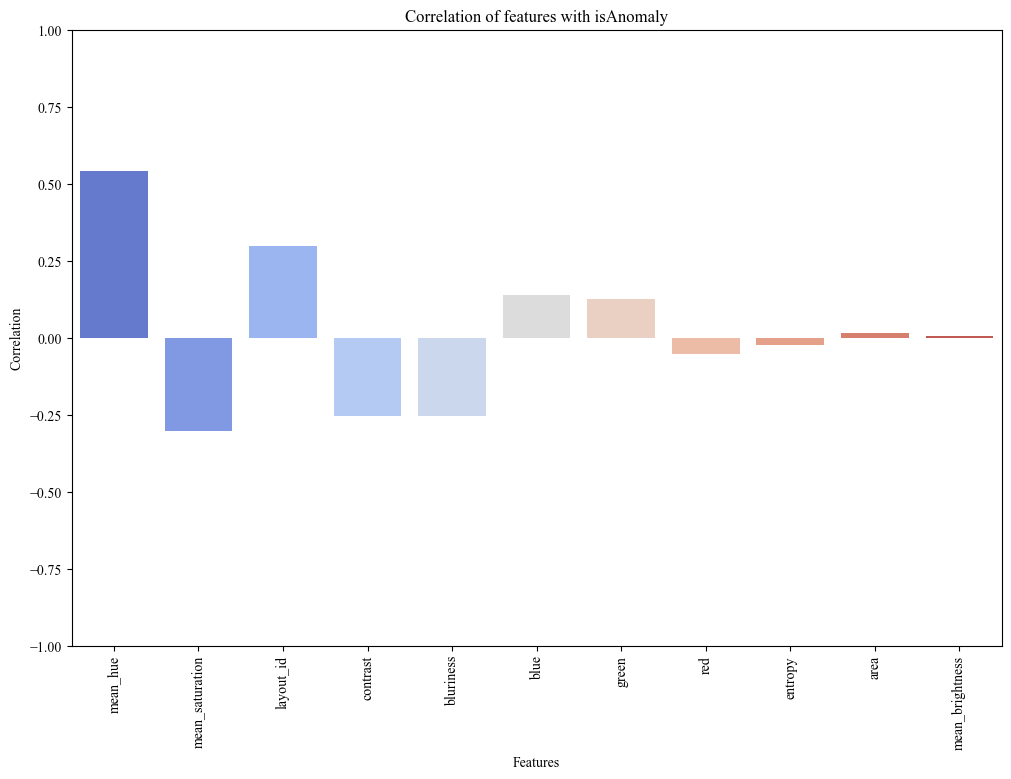

In [24]:
plt.figure(figsize=(12, 8))
sns.barplot(x=correlation_df.index, y=correlation_df['Correlation_with_isAnomaly'], palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlation of features with isAnomaly')
plt.ylabel('Correlation')
plt.xlabel('Features')
plt.ylim(-1, 1)
plt.show()

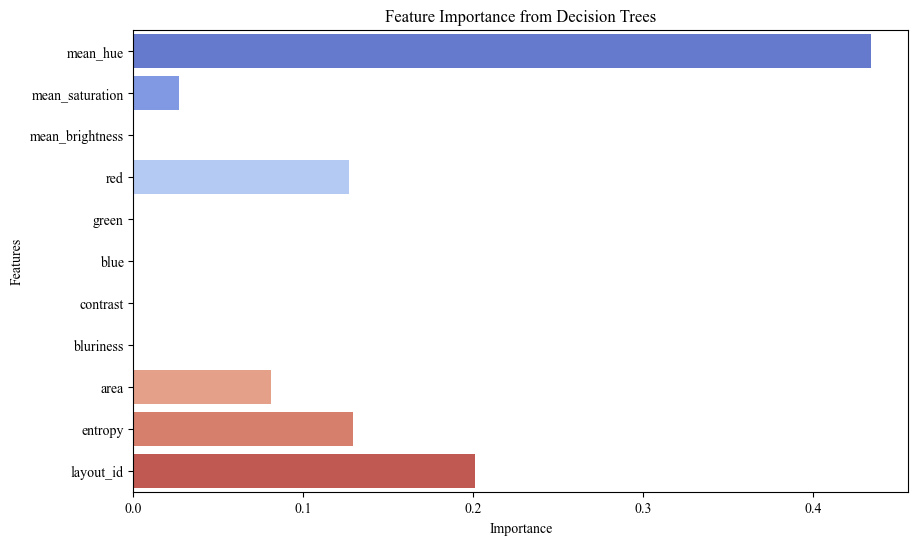

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifier = DecisionTreeClassifier()  # O RandomForestClassifier()
classifier.fit(imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1), imageFeatures_balanced['isAnomaly'])

feature_importance = classifier.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1).columns, palette='coolwarm')
plt.title('Feature Importance from Decision Trees')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

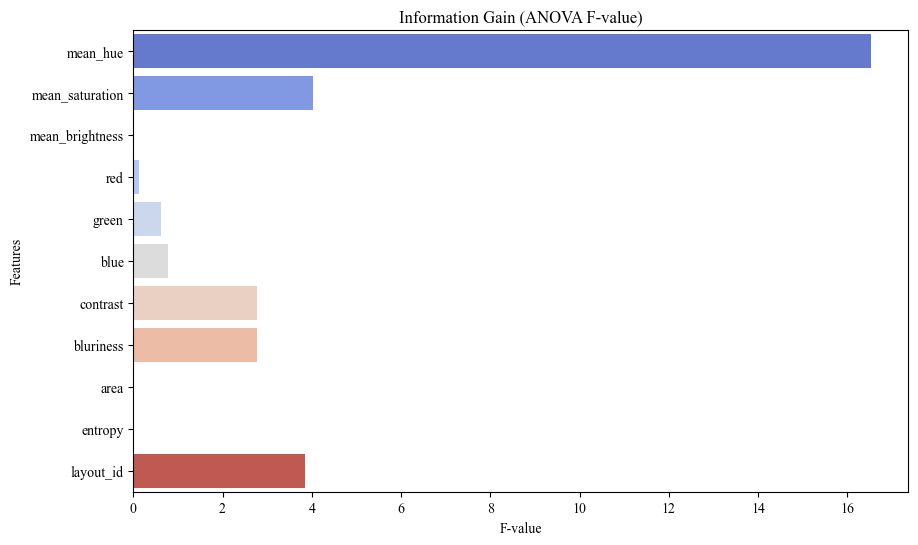

In [26]:
from sklearn.feature_selection import f_classif

f_values, _ = f_classif(imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1), imageFeatures_balanced['isAnomaly'])

plt.figure(figsize=(10, 6))
sns.barplot(x=f_values, y=imageFeatures_balanced.drop(['image_name', 'isAnomaly'], axis=1).columns, palette='coolwarm')
plt.title('Information Gain (ANOVA F-value)')
plt.xlabel('F-value')
plt.ylabel('Features')
plt.show()